In [1]:
import os

os.chdir("..")
print(f"Changed working directory to: {os.getcwd()}")

Changed working directory to: /home/jovyan/work/FlareSense


In [2]:
import torch
import src.utils.data as data
import matplotlib.pyplot as plt

from torchvision import transforms

# Settings
torch.manual_seed(0)

### Überprüfung der aller Daten

In [3]:
data_folder_path = "data/raw/burst_images/"

data_module = data.ECallistoDataModule(
    data_folder=data_folder_path,
    transform=transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((193, 240), antialias=True),
            transforms.ToTensor(),
        ]
    ),
    batch_size=32,
    num_workers=0,
    val_ratio=0.0,
    test_ratio=0.0,
)
data_module.setup()

In [4]:
data_module.observations

,file_path,start,end,instrument,label
0,data/raw/burst_images/no_burst/2023-01-29 04-4...,2023-01-29 04:47:00,2023-01-29 04:48:00,india_ooty_01,no_burst
1,data/raw/burst_images/no_burst/2022-07-24 14-2...,2022-07-24 14:29:00,2022-07-24 14:30:00,humain_59,no_burst
2,data/raw/burst_images/no_burst/2021-10-14 05-1...,2021-10-14 05:18:00,2021-10-14 05:19:00,australia_assa_02,no_burst
3,data/raw/burst_images/no_burst/2021-11-03 11-5...,2021-11-03 11:55:00,2021-11-03 11:56:00,glasgow_59,no_burst
4,data/raw/burst_images/no_burst/2021-02-26 07-1...,2021-02-26 07:12:00,2021-02-26 07:13:00,swiss_landschlacht_01,no_burst
...,...,...,...,...,...
86460,data/raw/burst_images/3/2021-08-29 02-08-00_20...,2021-08-29 02:08:00,2021-08-29 02:09:00,australia_assa_02,3
86461,data/raw/burst_images/5/2021-06-03 03-08-00_20...,2021-06-03 03:08:00,2021-06-03 03:09:00,australia_assa_02,5
86462,data/raw/burst_images/5/2021-05-21 05-14-00_20...,2021-05-21 05:14:00,2021-05-21 05:15:00,australia_assa_02,5
86463,data/raw/burst_images/5/2021-10-25 21-57-00_20...,2021-10-25 21:57:00,2021-10-25 21:58:00,australia_assa_02,5


In unserem ganzen Datensatz haben wir um die tausend Bilder mit Sunbursts variierender Grössen. Wir haben aber Verhältnissmässig viele Bilder, bei welchen keine Sunburst vorhanden sind (85k). Wir müssen also schauen, dass unser Modell nicht nur "no_burst" vorhersagt und eine super accuracy erreicht, sondern auch "burst" vorhersagen kann.

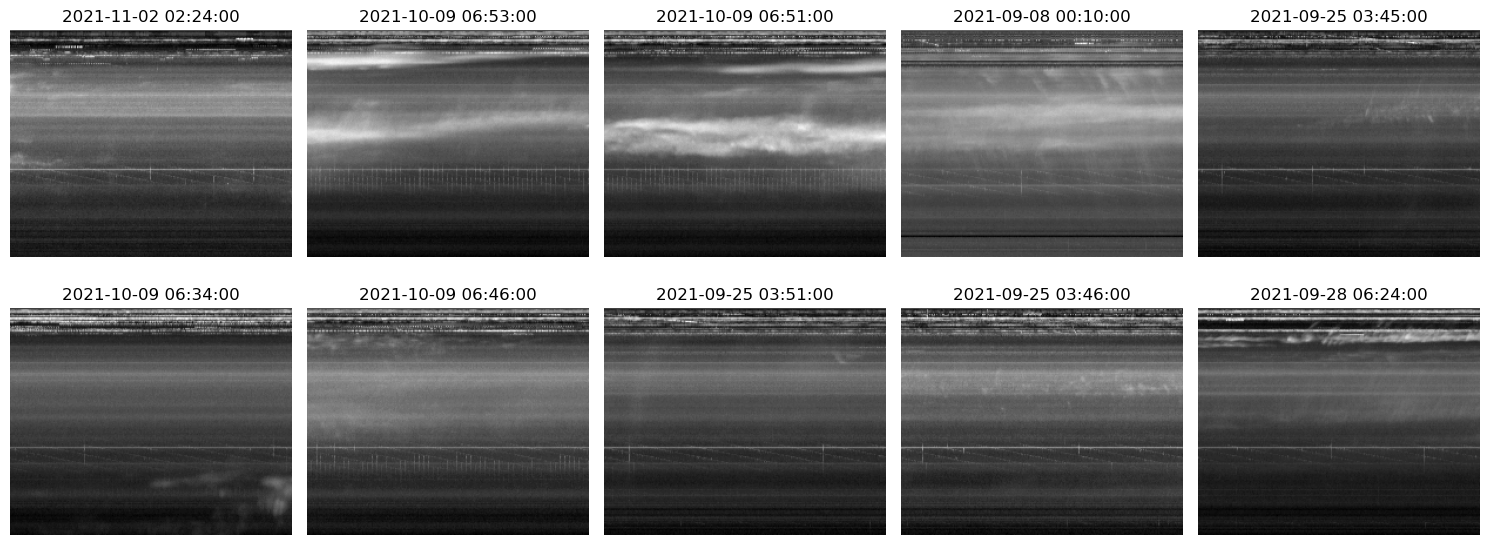

In [5]:
bursts = data_module.observations[data_module.observations.label != "no_burst"].head(10).reset_index(drop=True)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()
for i, burst in bursts.iterrows():
    axs[i].imshow(plt.imread(burst.file_path))
    axs[i].set_title(f"{burst.start}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()

Hier sehen wir wie diese Sonneneruptionen in den Spectrometer-Daten aussehen. Bei einigen sind die Muster ganz klar ersichtlich.

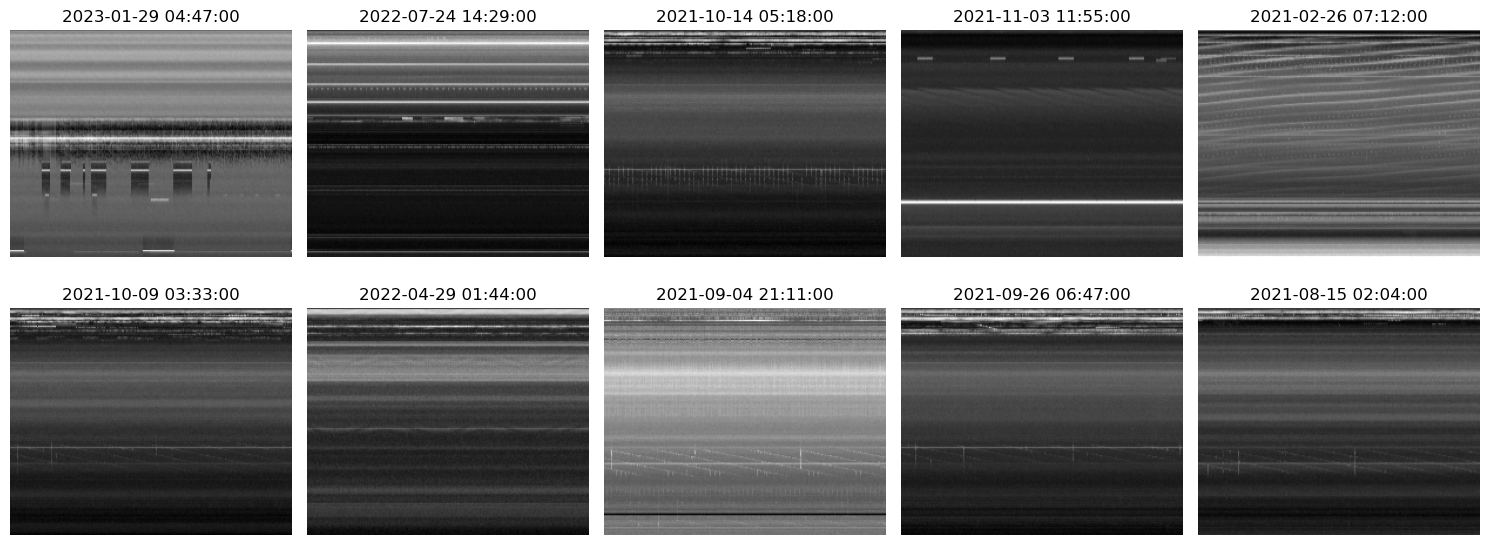

In [6]:
no_bursts = data_module.observations[data_module.observations.label == "no_burst"].head(10).reset_index(drop=True)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()
for i, burst in no_bursts.iterrows():
    axs[i].imshow(plt.imread(burst.file_path))
    axs[i].set_title(f"{burst.start}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()

Zum Vergleich sind hier einige Bilder ohne Sunburst. Trotz der Noise sollte ein Mensch diese Bilder eigentlich schon die Differenz zwischen Burst und no Burst in den meisten Fällen erkennen können.

In [7]:
data_module.observations[data_module.observations.label != "no_burst"].instrument.value_counts()

instrument
australia_assa_02    1183
Name: count, dtype: int64

Wir haben leider nur Sunbursts vom australia_assa_02 Instrument. Deshalb werden wir vorerst nur mit Daten dieses Insturmentes arbeiten.

In [8]:
data_module.observations.instrument.value_counts()

instrument
australia_assa_02        23645
alaska_haarp_62          17398
humain_59                15980
swiss_landschlacht_01     9550
australia_assa_62         8233
glasgow_59                6241
australia_assa_01         3140
india_ooty_01             2278
Name: count, dtype: int64

Insgesamt haben wir für das australia_assa_02 Instrument 23.6k Bilder. Dies sollte vorerst für ein Modell reichen. Eventuell müssen wir später noch mehr Daten sammeln.

### Überprüfung der Daten von australia_assa_02 mit Timesplit

In [9]:
data_folder_path = "data/raw/burst_images/"

data_module = data.ECallistoDataModule(
    data_folder=data_folder_path,
    transform=transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((193, 240), antialias=True),
            transforms.ToTensor(),
        ]
    ),
    batch_size=32,
    num_workers=0,
    val_ratio=0.15,
    test_ratio=0.15,
    split_by_date=True,
    filter_instruments=["australia_assa_02"],
)
data_module.setup()

Dataset split successfully
Train:		802 bursts
Validation:	232 bursts
Test:		149 bursts


Hier erstellen wir einen Datensplit by date. 70% der Tage gehen in den Trainingsdatensatz, 15% in den Validierungsdatensatz und 15% in den Testdatensatz. 

In [10]:
labels = data_module.observations.label.unique()
for name, observation_df in [
    ("Train", data_module.train_dataset.observations),
    ("Val", data_module.val_dataset.observations),
    ("Test", data_module.test_dataset.observations),
]:
    print(f"\n{name}:")
    instrument_counts = observation_df.instrument.value_counts()
    for instrument, count in instrument_counts.items():
        print(f"\tInstrument: {instrument}, Anzahl: {count}")
        for label in labels:
            label_count = len(
                observation_df[(observation_df.instrument == instrument) & (observation_df.label == label)]
            )
            print(f"\t\tLabel: {label}, Anzahl: {label_count}")


Train:
	Instrument: australia_assa_02, Anzahl: 1604
		Label: no_burst, Anzahl: 802
		Label: 2, Anzahl: 43
		Label: 6, Anzahl: 541
		Label: 4, Anzahl: 9
		Label: 3, Anzahl: 206
		Label: 5, Anzahl: 3

Val:
	Instrument: australia_assa_02, Anzahl: 3971
		Label: no_burst, Anzahl: 3739
		Label: 2, Anzahl: 38
		Label: 6, Anzahl: 94
		Label: 4, Anzahl: 6
		Label: 3, Anzahl: 93
		Label: 5, Anzahl: 1

Test:
	Instrument: australia_assa_02, Anzahl: 3264
		Label: no_burst, Anzahl: 3115
		Label: 2, Anzahl: 13
		Label: 6, Anzahl: 97
		Label: 4, Anzahl: 0
		Label: 3, Anzahl: 39
		Label: 5, Anzahl: 0


Da wir einen Timesplit machen, haben wir leider nicht eine perfekte Verteilung von Burst und no Burst Bildern.<br>
Dies kann je nach random seed variieren, sodass Modellmetriken stark variieren können.

### Überprüfung der Daten von australia_assa_02 ohne Timesplit

In [11]:
# Als DataModule (Trainings-, Validierungs- und Testdaten unterteilt)
data_folder_path = "data/raw/burst_images/"

data_module = data.ECallistoDataModule(
    data_folder=data_folder_path,
    transform=transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((193, 240), antialias=True),
            transforms.ToTensor(),
        ]
    ),
    batch_size=32,
    num_workers=0,
    val_ratio=0.15,
    test_ratio=0.15,
    split_by_date=False,
    filter_instruments=["australia_assa_02"],
)
data_module.setup()

Hier erstellen wir einen class stratified Split. 70% der Tage gehen in den Trainingsdatensatz, 15% in den Validierungsdatensatz und 15% in den Testdatensatz. 

In [12]:
labels = data_module.observations["label"].unique()
for name, observation_df in [
    ("Train", data_module.train_dataset.observations),
    ("Val", data_module.val_dataset.observations),
    ("Test", data_module.test_dataset.observations),
]:
    print(f"\n{name}:")
    instrument_counts = observation_df["instrument"].value_counts()
    for instrument, count in instrument_counts.items():
        print(f"\tInstrument: {instrument}, Anzahl: {count}")
        for label in labels:
            label_count = len(
                observation_df[(observation_df["instrument"] == instrument) & (observation_df["label"] == label)]
            )
            print(f"\t\tLabel: {label}, Anzahl: {label_count}")


Train:
	Instrument: australia_assa_02, Anzahl: 1666
		Label: no_burst, Anzahl: 833
		Label: 2, Anzahl: 66
		Label: 6, Anzahl: 514
		Label: 4, Anzahl: 11
		Label: 3, Anzahl: 238
		Label: 5, Anzahl: 4

Val:
	Instrument: australia_assa_02, Anzahl: 3492
		Label: no_burst, Anzahl: 3317
		Label: 2, Anzahl: 14
		Label: 6, Anzahl: 109
		Label: 4, Anzahl: 2
		Label: 3, Anzahl: 50
		Label: 5, Anzahl: 0

Test:
	Instrument: australia_assa_02, Anzahl: 3599
		Label: no_burst, Anzahl: 3424
		Label: 2, Anzahl: 14
		Label: 6, Anzahl: 109
		Label: 4, Anzahl: 2
		Label: 3, Anzahl: 50
		Label: 5, Anzahl: 0


Hier sehen wir, dass die Verteilung von Burst und no Burst Bildern sehr gut ist. Der Nachteil an diesem Split ist jedoch, dass die Gefahr besteht, dass von der gleichen Burst Epoche (z.B. 15:06 bis 15:12) Bilder in den Trainings-, Validierungs- und Testdatensatz kommen. Beziehungsweise "bleeded" der Trainingsdatensatz in den Validierungs- und Testdatensatz. Somit werden die Metriken des Modells um einen bestimmten Grad verfälscht. <br>

Deswegen entscheiden wir uns vorerst für den Timesplit.